In [ ]:
# TODO: Code for KDE needed from Dominik

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Listening Events Threshold

In [2]:
LE_kde_df = pd.read_csv("../MusicRecommender/events_kde.csv", sep=",", header=None).T
LE_kde_df.columns = ["x", "y"]
LE_kde_df.head()

,x,y
0,-2765.918720,1.603734e-07
1,-2525.463307,3.583183e-07
2,-2285.007894,7.570544e-07
3,-2044.552481,1.506490e-06
4,-1804.097068,2.823188e-06


In [3]:
LE_gradient = np.gradient(LE_kde_df["y"])

In [5]:
indices = np.where(np.abs(LE_gradient) < 0.000001)[0]
longest_seq, current_seq = [], []
for v in indices:
    if len(current_seq) == 0:
        current_seq.append(v)
    else:
        if current_seq[-1] == v-1:
            current_seq.append(v)
        elif len(longest_seq) < len(current_seq):
            longest_seq = current_seq
            current_seq = [v]

print("The longest consecutive sequence of points with a gradient < 0.000001 goes from %d to %d" % (LE_kde_df.iloc[longest_seq[0]]["x"], LE_kde_df.iloc[longest_seq[-1]]["x"]))

The longest consecutive sequence of points with a gradient < 0.000001 goes from 4688 to 14787


Text(0.5, 0, 'No. of listening events per user')

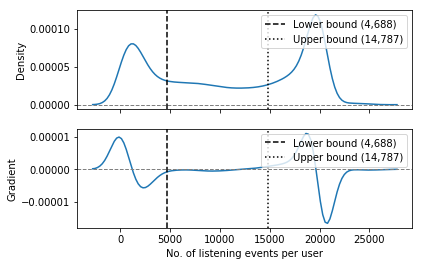

In [6]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(LE_kde_df["x"], LE_kde_df["y"], label="")
axes[0].axhline(y=0, linestyle="--", color="grey", linewidth=1)
axes[0].axvline(x=4688, linestyle="--", c="black", label="Lower bound (4,688)")
axes[0].axvline(x=14787, linestyle="dotted", c="black", label="Upper bound (14,787)")
axes[0].legend(loc="upper right")
axes[0].set_ylabel("Density")
axes[0].grid(False)

axes[1].plot(LE_kde_df["x"], LE_gradient, label="")
axes[1].axhline(y=0, linestyle="--", color="grey", linewidth=1)
axes[1].axvline(x=4688, linestyle="--", c="black", label="Lower bound (4,688)")
axes[1].axvline(x=14787, linestyle="dotted", c="black", label="Upper bound (14,787)")
axes[1].set_ylabel("Gradient")
axes[1].grid(False)
axes[1].legend(loc="upper right")

plt.xlabel("No. of listening events per user")

# Mainstreaminess Threshold

In [7]:
M_kde_df = pd.read_csv("../MusicRecommender/mainstreaminess_kde.csv", sep=",", header=None).T
M_kde_df.columns = ["x", "y"]
M_kde_df.head()

,x,y
0,-0.313671,0.000028
1,-0.305909,0.000130
2,-0.298147,0.000488
3,-0.290384,0.001331
4,-0.282622,0.002717


In [14]:
M_gradient = np.gradient(M_kde_df["y"])
max_gradient = M_kde_df.iloc[np.argmax(M_gradient)]["x"]
print("The point with the maximal gradient is %f" % max_gradient)

The point with the maximal gradient is 0.097732


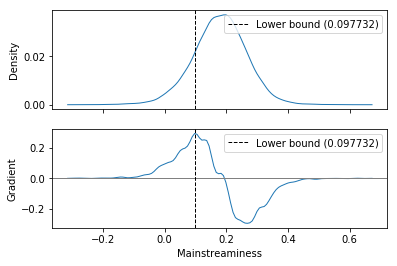

In [15]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(M_kde_df["x"], M_kde_df["y"] / len(M_kde_df), label="", linewidth=1)
axes[0].axvline(x=0.097732, linestyle="--", c="black", label="Lower bound (0.097732)", linewidth=1)
axes[0].set_ylabel("Density")
axes[0].grid(False)
axes[0].legend(loc="upper right")

axes[1].plot(M_kde_df["x"], M_gradient, linewidth=1)
axes[1].axhline(y=0, linestyle="-", c="grey", linewidth=1)
axes[1].axvline(x=0.097732, linestyle="--", c="black", label="Lower bound (0.097732)", linewidth=1)
#axes[1].axvline(x=0.268503, linestyle="dotted", c="black", label="min. gradient (0.268503)")
axes[1].set_ylabel("Gradient")
axes[1].grid(False)
plt.xlabel("Mainstreaminess")
plt.legend(loc="upper right")